# <span style="color:blue">Pre-analysis to find the optimal number of topics and hyperparameters values (2019_Mar)</span>

In [1]:
yyyy_MMM = '2019_Mar'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if debug is True, messages during the process are generated
debug = False
# for debugging purposes sample may be used to work with a smaller amount of data (when 0 it is not applied)
sample = 0
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = False

if test:
    # path where the doc files are stored
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where the model files are stored
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model_hyperparameter'
    # LDA chunksize
    chunksize = 250
else:
    # path where the doc files are stored
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where the model files are stored
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model_hyperparameter'
    # LDA chunksize
    chunksize = 5000

file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc\2019_Mar\2019_Mar_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model_hyperparameter\2019_Mar\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc)
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                          ['brown', 'beige', 'store']
1    ['well', 'hand', 'left', 'hand', 'trigger', 't...
2    ['processing', 'drunken', 'group', 'vocal', 'p...
3    ['tomorrow', 'italy', 'global', 'fashion', 'tr...
4       ['hello', 'deeply', 'soothe', 'lunch', 'view']
5    ['construction', 'worker', 'realness', 'constr...
6    ['house', 'live', 'life', 'seychelles', 'islan...
7    ['uuuu', 'fantasy', 'sport', 'erotica', 'creep...
8    ['share', 'butterfinger', 'double', 'chocolate...
9    ['flashback', 'time', 'week', 'board', 'york',...
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


123850                  ['good', 'morning', 'york', 'city']
55717     ['hannah', 'york', 'fashion', 'portrait', 'sty...
30032     ['mood', 'nude', 'isabella', 'kravitz', 'creat...
47469     ['kick', 'trip', 'lion', 'coffee', 'morning', ...
84298     ['good', 'light', 'friday', 'foundation', 'yes...
65343     ['paros', 'island', 'greek', 'island', 'clade'...
109401    ['plant', 'gentle', 'reminder', 'plant', 'seed...
31892     ['ready', 'halloween', 'collaboration', 'plan'...
76961     ['sunday', 'review', 'rufus', 'maldives', 'blo...
82562     ['work', 'amaze', 'talented', 'powerful', 'bea...
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text  
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Function to compute bigrams & trigrams  
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [8]:
# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Function for categorizing and tagging words

In [9]:
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Analysis to get the optimal number of topics  
https://towardsdatascience.com/discover-what-singaporeans-generally-talk-on-sms-d4b592a682fd

In [10]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
model_list = []
coherence_score = []
model_topics = []

for num_topics in range(8, 12, 1):
    
    time_start = time.time()

    lda_x = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=10)
    coherence_lda_model = CoherenceModel(model=lda_x, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    model_topics.append(num_topics)
    model_list.append(lda_x)
    
    print("# Topics: " + str(num_topics) + " Score: " + str(coherence))
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topics: 8 Score: 0.5559799185961412
time elapsed - 00:04:49.34
# Topics: 9 Score: 0.5768815735030097
time elapsed - 00:05:09.05
# Topics: 10 Score: 0.5792560217568525
time elapsed - 00:05:08.94
# Topics: 11 Score: 0.5799398861073534
time elapsed - 00:04:57.11


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


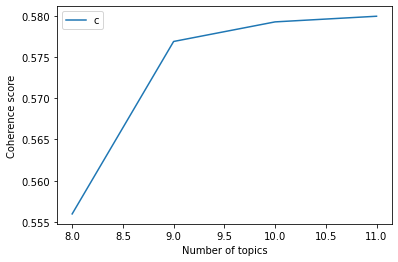

In [12]:
limit=12; start=8; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_score)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Hyperparameter tuning  

https://medium.com/analytics-vidhya/analyzing-amazon-tv-reviews-with-latent-dirichlet-allocation-97d19c3bb878  
https://github.com/Georgebob256/Machine-learning-with-Python/blob/master/Amazon%20TV%20reviews..ipynb

In [ ]:
# LDA model and its corresponding Coherence Score
def compute_coherence_values(bow_corpus, id2word, n, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus
                                           ,id2word=id2word
                                           ,num_topics=n
                                           ,random_state=random_state
                                           ,chunksize=chunksize
                                           ,passes=10
                                           ,alpha=a
                                           ,eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 8
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = [0.01, 0.31, 0.61, 0.91, 'symmetric', 'asymmetric']

# Beta parameter
beta = [0.01, 0.31, 0.61, 0.91, 'symmetric']

model_results = {'Topics': []
                 ,'Alpha': []
                 ,'Beta': []
                 ,'Coherence': []
                }

# iterate through number of topics
iter = 0
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            iter += 1
            # get the coherence score for the given parameters
            cv = compute_coherence_values(bow_corpus=corpus
                                          ,id2word=id2word
                                          ,n=k
                                          ,a=a
                                          ,b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            print('Iteration num - ', iter, ' Topics - ', k, ' Alpha - ', a, ' Beta - ', b, ' Coherence - ', cv)

pd.DataFrame(model_results).to_csv(file_model + '_lda_tuning_results.csv', index=False)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration num -  1  Topics -  8  Alpha -  0.01  Beta -  0.01  Coherence -  0.564717397194646
Iteration num -  2  Topics -  8  Alpha -  0.01  Beta -  0.31  Coherence -  0.5525550309439746
Iteration num -  3  Topics -  8  Alpha -  0.01  Beta -  0.61  Coherence -  0.5388814963763793


In [ ]:
pd.DataFrame(model_results).sort_values(by=['Coherence'], ascending=False)